In [1]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn as nn
%matplotlib inline
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import torch.nn.functional as F
from IPython.display import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Normalized Value= (Pixel Value−Mean)/Standard Deviation
DATA_DIR="/content/drive/MyDrive/Anime Face Generation"

image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
T.Resize(image_size),
T.CenterCrop(image_size),
T.ToTensor(),
T.Normalize(*stats)]))
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]

In [5]:
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

In [6]:
def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

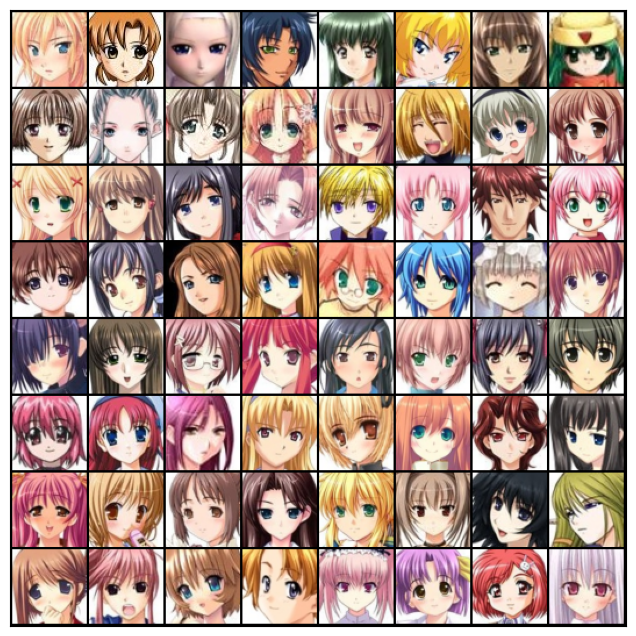

In [ ]:
##################################################
show_batch(train_dl)

In [7]:
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")

def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [8]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)

In [9]:
discriminator = nn.Sequential(
# in: 3 x 64 x 64
nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
nn.BatchNorm2d(64),
nn.LeakyReLU(0.2, inplace=True),
# out: 64 x 32 x 32
nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
nn.BatchNorm2d(128),
nn.LeakyReLU(0.2, inplace=True),
# out: 128 x 16 x 16
nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
nn.BatchNorm2d(256),
nn.LeakyReLU(0.2, inplace=True),
# out: 256 x 8 x 8
nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
nn.BatchNorm2d(512),
nn.LeakyReLU(0.2, inplace=True),
# out: 512 x 4 x 4
nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
# out: 1 x 1 x 1
nn.Flatten(),
nn.Sigmoid())

In [10]:
discriminator = to_device(discriminator, device)

In [11]:
latent_size = 128
generator = nn.Sequential(
# in: latent_size x 1 x 1
nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
nn.BatchNorm2d(512),
nn.ReLU(True),
# out: 512 x 4 x 4
nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
nn.BatchNorm2d(256),
nn.ReLU(True),
# out: 256 x 8 x 8
nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
nn.BatchNorm2d(128),
nn.ReLU(True),
# out: 128 x 16 x 16
nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
nn.BatchNorm2d(64),
nn.ReLU(True),
# out: 64 x 32 x 32
nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
nn.Tanh()
# out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


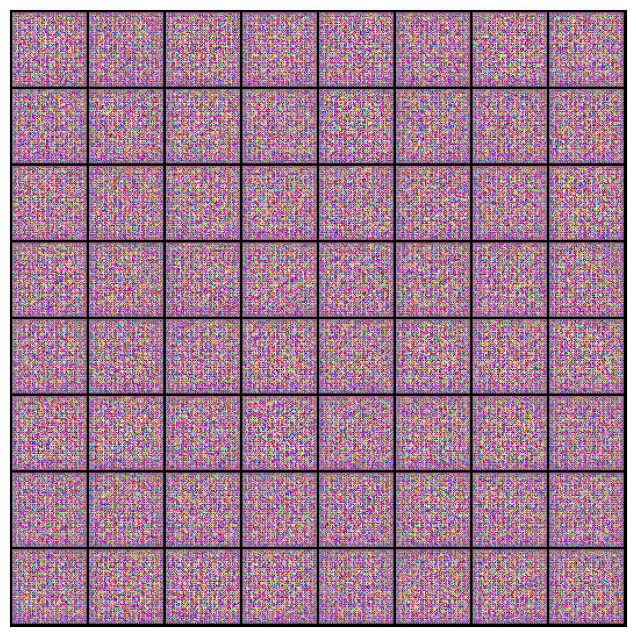

In [12]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [13]:
generator = to_device(generator, device)

In [14]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()
    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [15]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    # Update generator weights
    loss.backward()
    opt_g.step()
    return loss.item()

In [16]:
import os
sample_dir = "generated"
os.makedirs(sample_dir, exist_ok=True)

In [17]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = "generated-images-{0:0=4d}.png".format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print("Saving", fake_fname)
    if show:
      fig, ax = plt.subplots(figsize=(8, 8))
      ax.set_xticks([]); ax.set_yticks([])
      ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Saving generated-images-0000.png


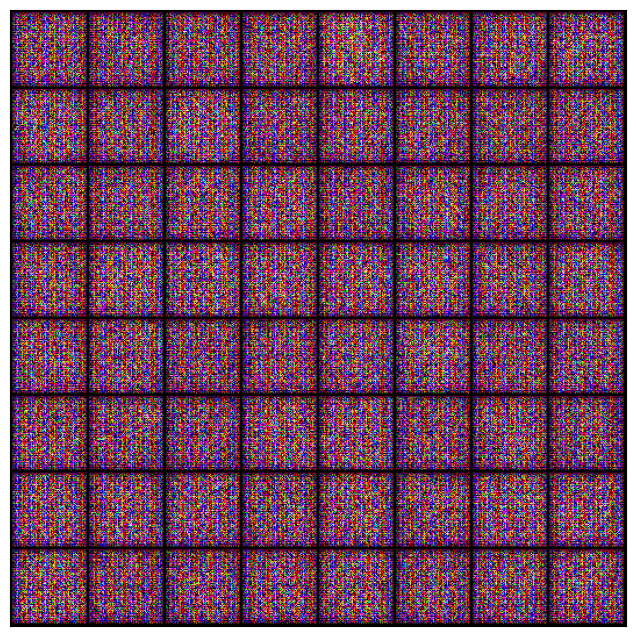

In [18]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)

In [19]:
# def fit(epochs, lr, start_idx=1):
#     torch.cuda.empty_cache()
#     # Losses & scores
#     losses_g = []
#     losses_d = []
#     real_scores = []
#     fake_scores = []
#     # Create optimizers
#     opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
#     opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
#     for epoch in range(epochs):
#       for real_images, _ in tqdm(train_dl):
#       # Train discriminator
#         loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
#         # Train generator
#         loss_g = train_generator(opt_g)
#         # Record losses & scores
#         losses_g.append(loss_g)
#         losses_d.append(loss_d)
#         real_scores.append(real_score)
#         fake_scores.append(fake_score)
#         # Log losses & scores (last batch)
#         print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
#         epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
#         # Save generated images
#         save_samples(epoch+start_idx, fixed_latent, show=False)
#     return losses_g, losses_d, real_scores, fake_scores



def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Adjusted optimizer betas to commonly used GAN values
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):  # Fixed indentation
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)

            losses_g.append(loss_g)
            losses_d.append(loss_d)
            real_scores.append(real_score)
            fake_scores.append(fake_score)

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        save_samples(epoch + start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores


In [20]:
lr = 0.0002
epochs = 25

In [21]:
history = fit(epochs, lr)

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 4.0987, loss_d: 0.3753, real_score: 0.8276, fake_score: 0.1413
Saving generated-images-0001.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 3.4009, loss_d: 0.6875, real_score: 0.6028, fake_score: 0.0621
Saving generated-images-0002.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 3.3307, loss_d: 0.4550, real_score: 0.7715, fake_score: 0.1248
Saving generated-images-0003.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 6.4034, loss_d: 0.9006, real_score: 0.5020, fake_score: 0.0061
Saving generated-images-0004.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 2.6936, loss_d: 0.2870, real_score: 0.8450, fake_score: 0.0783
Saving generated-images-0005.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 5.9011, loss_d: 0.2752, real_score: 0.8278, fake_score: 0.0398
Saving generated-images-0006.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 4.9240, loss_d: 0.3084, real_score: 0.8218, fake_score: 0.0576
Saving generated-images-0007.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 4.0593, loss_d: 0.8418, real_score: 0.5311, fake_score: 0.0136
Saving generated-images-0008.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 8.1963, loss_d: 0.2870, real_score: 0.7968, fake_score: 0.0032
Saving generated-images-0009.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 4.6464, loss_d: 0.6267, real_score: 0.6312, fake_score: 0.0083
Saving generated-images-0010.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 7.5130, loss_d: 0.5492, real_score: 0.9363, fake_score: 0.3541
Saving generated-images-0011.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 5.0134, loss_d: 0.1601, real_score: 0.9430, fake_score: 0.0861
Saving generated-images-0012.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 6.7060, loss_d: 0.3976, real_score: 0.9186, fake_score: 0.2523
Saving generated-images-0013.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 6.5007, loss_d: 0.3339, real_score: 0.9182, fake_score: 0.1989
Saving generated-images-0014.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 6.2879, loss_d: 0.2761, real_score: 0.9950, fake_score: 0.1906
Saving generated-images-0015.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 2.5654, loss_d: 0.0835, real_score: 0.9950, fake_score: 0.0708
Saving generated-images-0016.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 5.6278, loss_d: 0.1925, real_score: 0.8512, fake_score: 0.0053
Saving generated-images-0017.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 3.0372, loss_d: 0.0844, real_score: 0.9539, fake_score: 0.0321
Saving generated-images-0018.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 6.4198, loss_d: 0.2181, real_score: 0.9461, fake_score: 0.1376
Saving generated-images-0019.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 4.3308, loss_d: 0.3110, real_score: 0.8220, fake_score: 0.0702
Saving generated-images-0020.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 7.5429, loss_d: 0.0435, real_score: 0.9689, fake_score: 0.0071
Saving generated-images-0021.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 5.2806, loss_d: 0.1440, real_score: 0.9754, fake_score: 0.1037
Saving generated-images-0022.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 6.3707, loss_d: 0.0472, real_score: 0.9745, fake_score: 0.0194
Saving generated-images-0023.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 16.1540, loss_d: 1.3278, real_score: 0.9997, fake_score: 0.6500
Saving generated-images-0024.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 5.2539, loss_d: 0.0284, real_score: 0.9910, fake_score: 0.0185
Saving generated-images-0025.png
